In [1]:
import os
import copy
import math
import json
from functools import partial

import h5py
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.colors import Normalize
from scipy.stats import norm, uniform

from jax import numpy as jnp
from jax import jit
import multihist as mh

from appletree.randgen import TwoHalfNorm

import emcee

from sklearn.decomposition import PCA

import appletree as apt
from appletree import randgen
from appletree.plugin import Plugin
from appletree.component import ComponentSim
from appletree.utils import load_json, get_file_path
from appletree.share import _cached_configs, _cached_functions

import aptext

In [2]:
matplotlib.style.use('default')
plt.rcParams['savefig.dpi'] = 100
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['xtick.labelsize'] = 15
plt.rcParams['ytick.labelsize'] = 15
plt.rcParams['axes.labelsize'] = 15
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['patch.linewidth'] = 2.0
plt.rcParams['axes.grid'] = True

In [3]:
home = os.path.expanduser('~')

# Read posterior distribution

In [4]:
ER = True
# ER = False

In [5]:
if ER:
    backend = emcee.backends.HDFBackend('/home/xudc/analysiscode/band_fit/mcmc_rn220_building.h5', read_only=True)
else:
    backend = emcee.backends.HDFBackend('/home/xudc/analysiscode/band_fit/mcmc_ambe_building.h5', read_only=True)

In [6]:
tau = backend.get_autocorr_time(tol=0)
burnin = int(2 * np.max(tau))
thin = int(0.5 * np.min(tau))

chain = backend.get_chain(discard=burnin, flat=True, thin=thin)

In [7]:
with h5py.File(backend.filename, 'r', libver='latest', swmr=True) as opt:
    name = 'mcmc'
    metadata = json.loads(opt[name].attrs['metadata'])
    par_config = json.loads(opt[name].attrs['par_config'])
    post_parameters = json.loads(opt[name].attrs['post_parameters'])
    parameter_fit = list(opt[name].attrs['parameter_fit'])

ind_map = {par : i for i, par in enumerate(parameter_fit)}

if ER:
    features = ['py0', 'py1', 'py2', 'py3', 'py4', 'p_dpe', 'w', 'nex_ni_ratio', 'g1', 'g2']
else:
    features = ['alpha', 'beta', 'eta', 'gamma', 'kappa', 'lambda', 'p_dpe', 'w', 'g1', 'g2']

ind_keep = [ind_map[par] for par in features]

# Fit PCA

In [8]:
x1 = chain[:, ind_keep]
pca = PCA(n_components=len(features))
_ = pca.fit_transform(x1)

In [9]:
DF = pd.DataFrame(
    x1,
    columns=features
)

t_DF = pd.DataFrame(
    pca.transform(x1),
    columns=[f'PCA{i}' for i in range(1, pca.n_components_ + 1)]
)

In [10]:
one_sigma = pca.inverse_transform(np.diag(pca.explained_variance_**.5))
# center = x1[np.argmax(plt_manager.flat_log_prob), :][None, :]
center = pca.inverse_transform(np.zeros((pca.n_components_, pca.n_components_)))

df = pd.DataFrame(
    one_sigma - center,
    index=[f'PCA{i}' for i in range(1, pca.n_components_ + 1)],
    columns=features
)
# df.to_csv('PCA_230207.csv')

In [11]:
# to test the unitary matrix

m = one_sigma - center
m /= np.linalg.norm(m, axis=1)[:, None]

assert np.mean(np.eye(len(m)) - np.matmul(m, m.T)) < 1e-10

In [12]:
df

,py0,py1,py2,py3,py4,p_dpe,w,nex_ni_ratio,g1,g2
PCA1,-0.000265,6.136604e+00,-1.355468e-02,9.982794e-02,-4.704269e-02,-2.203741e-04,0.000021,1.254227e-02,1.692514e-04,-9.645083e-02
PCA2,-0.001087,1.063916e-02,2.048929e-02,-3.137576e-02,-3.573789e-02,-7.930644e-04,-0.000003,3.704782e-03,2.969787e-05,6.594714e-01
PCA3,-0.000275,7.182318e-03,3.125465e-03,-3.810270e-01,1.466403e-01,-2.334573e-04,0.000016,-7.638668e-03,5.222800e-05,-1.035228e-02
PCA4,0.001293,1.689620e-04,-8.901003e-03,3.448401e-02,9.178328e-02,-5.022596e-04,0.000031,2.923540e-02,5.280548e-05,6.725653e-03
PCA5,0.022081,-1.065937e-04,-5.542254e-02,-2.794857e-03,-5.773457e-03,-5.211260e-04,-0.000003,3.265158e-03,1.070117e-05,1.295249e-03
PCA6,0.000317,4.815069e-06,-2.277605e-04,1.846371e-04,4.569658e-04,2.331221e-02,0.000020,-1.353183e-03,1.200854e-04,7.670078e-05
PCA7,-0.002589,-4.927332e-05,8.077390e-04,-2.435298e-03,-5.335171e-03,1.337399e-03,-0.000065,2.013124e-02,-7.437772e-06,-5.450418e-04
PCA8,0.002151,1.101370e-06,8.722715e-04,-4.930161e-06,-1.670003e-05,-2.713466e-06,0.000013,2.359316e-04,-7.523946e-04,-2.600584e-05
PCA9,0.000369,1.438441e-07,1.501259e-04,-1.018195e-06,-3.795133e-06,-7.470842e-06,0.000007,4.117567e-05,1.242698e-03,-4.608406e-06
PCA10,-0.000001,-2.886708e-09,-4.631670e-07,-8.055667e-08,-2.001552e-07,-1.202180e-07,0.000195,4.317751e-07,-7.039653e-07,-4.010349e-09


# Demo components

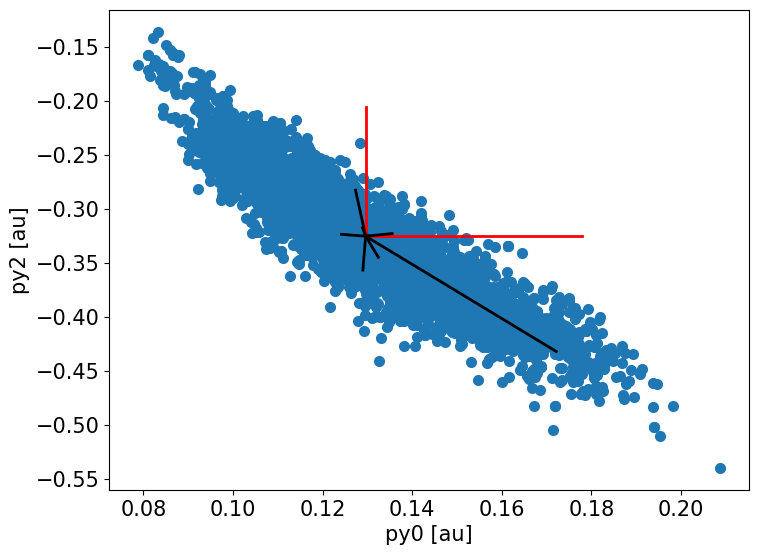

In [13]:
if ER:
    labels = ['py0', 'py2']
else:
    labels = ['alpha', 'gamma']

_im = [features.index(label) for label in labels]
quantile = 0.98

fig = plt.figure(figsize=(8, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.25, hspace=0.25)
ax = fig.add_subplot(gs[0, 0])

ax.scatter(DF[labels[0]], DF[labels[1]])

mcmean = DF.mean()
mcquantile = DF.quantile(quantile)

xx = np.array([mcmean[labels[0]], mcquantile[labels[0]]])
yy = np.array([mcmean[labels[1]], mcmean[labels[1]]])
ax.plot(xx, yy, zorder=3, linewidth=2, color='r')
xx = np.array([mcmean[labels[0]], mcmean[labels[0]]])
yy = np.array([mcmean[labels[1]], mcquantile[labels[1]]])
ax.plot(xx, yy, zorder=3, linewidth=2, color='r')

dcmean = t_DF.mean()
dcquantile = t_DF.quantile(quantile)

# ax.scatter(mcmean[labels[0]], mcmean[labels[1]], color='r', s=16.0)

for i in range(pca.n_components_):
    vec = dcmean.copy()
    vec[i] = dcquantile[i]
    vec = pca.inverse_transform(vec)

    xx = np.array([mcmean[labels[0]], vec[_im[0]]])
    yy = np.array([mcmean[labels[1]], vec[_im[1]]])
    ax.plot(xx, yy, zorder=3, linewidth=2, color='k')

ax.set_xlabel(labels[0] + ' [' + par_config[labels[0]]['unit'] + ']')
ax.set_ylabel(labels[1] + ' [' + par_config[labels[1]]['unit'] + ']')
ax.grid()

plt.show()

# Draw posterior distributions

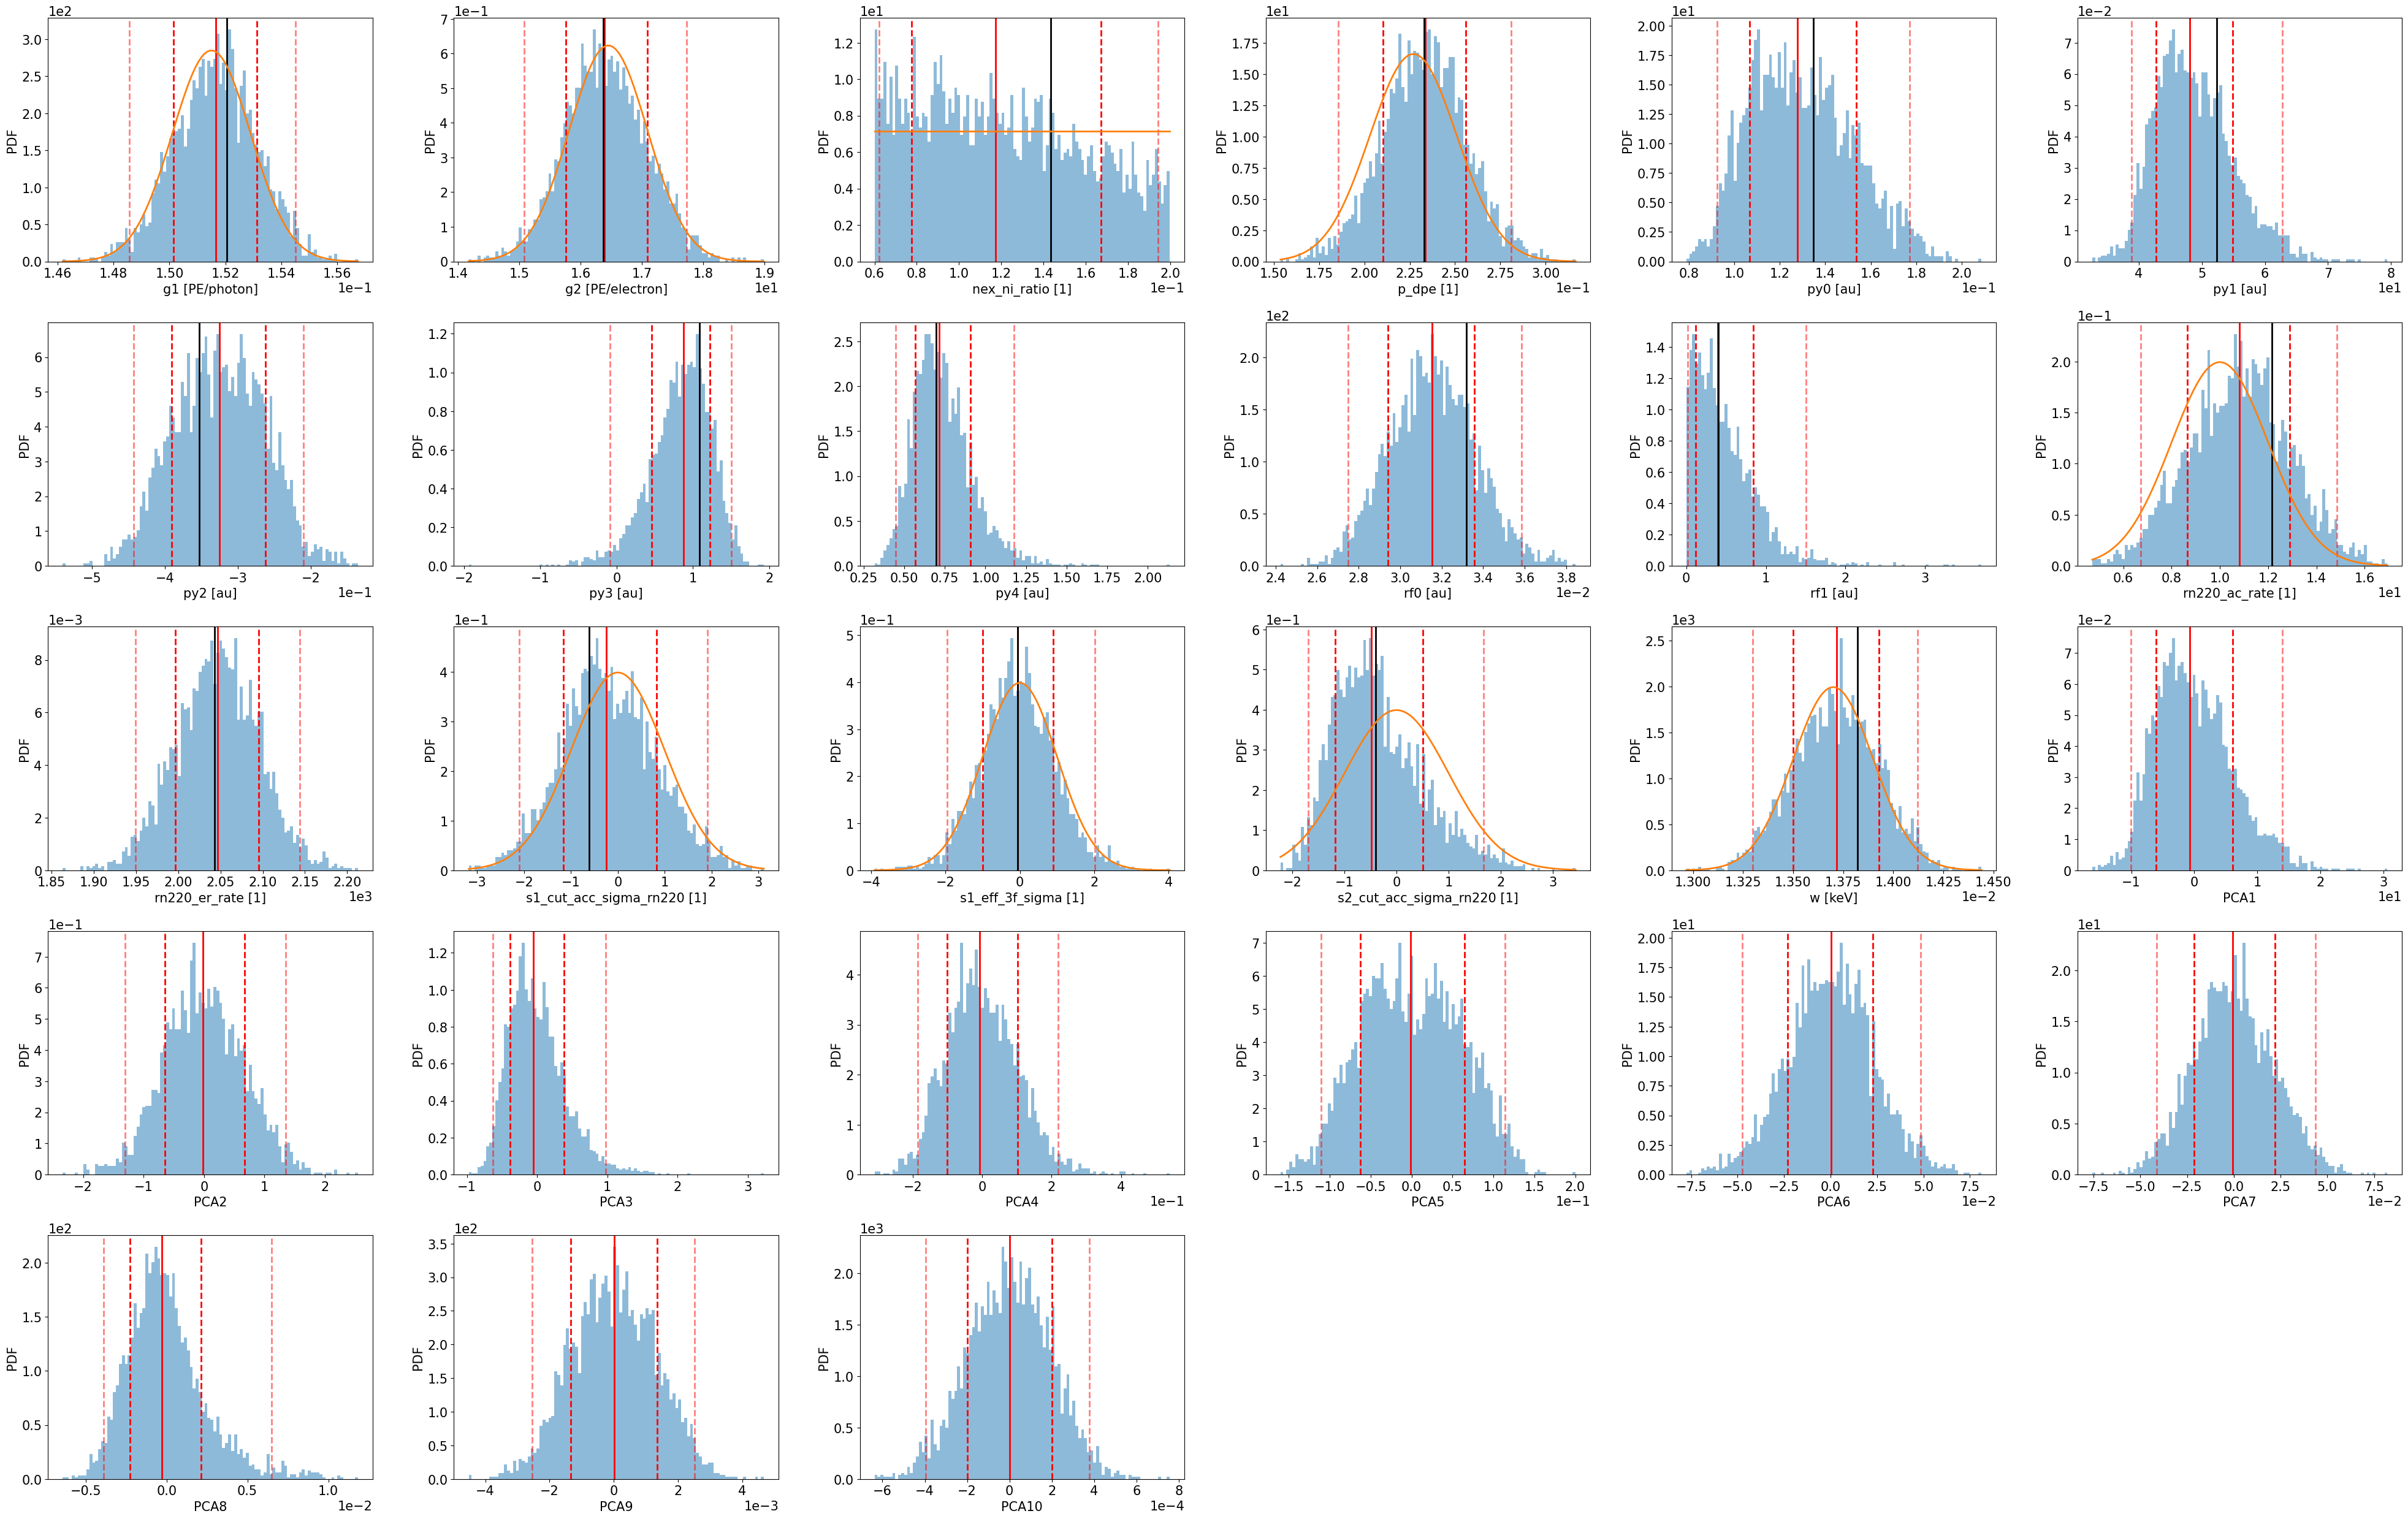

In [14]:
labels = parameter_fit + list(t_DF.columns)
n_sub = math.ceil(len(labels) ** 0.5)

fig = plt.figure(figsize=(8 * n_sub, 6 * n_sub))
# fig.tight_layout()
gs = gridspec.GridSpec(n_sub, n_sub, figure=fig, left=0.15, right=0.95, top=0.95, bottom=0.15, wspace=0.25, hspace=0.25)

n_bins = 100
for i, key in enumerate(labels):
    ax = fig.add_subplot(gs[i // n_sub, i % n_sub])
    try:
        samples = chain[:, ind_map[key]]
    except:
        samples = t_DF[key].values
    h = ax.hist(samples, bins=n_bins, density=True, alpha=0.5)
    x = h[1]
    ax.axvline(np.quantile(samples, norm.cdf(0)), color='r')
    ax.axvline(np.quantile(samples, norm.cdf(-1)), color='r', linestyle='dashed')
    ax.axvline(np.quantile(samples, norm.cdf(1)), color='r', linestyle='dashed')
    ax.axvline(np.quantile(samples, norm.cdf(-2)), color='r', linestyle='dashed', alpha=0.5)
    ax.axvline(np.quantile(samples, norm.cdf(2)), color='r', linestyle='dashed', alpha=0.5)
    if key in par_config.keys():
        ax.axvline(post_parameters[key], color='k')
        if par_config[key]['prior_type'] == 'norm':
            ax.plot(
                x, 
                norm.pdf(
                    x, 
                    loc=par_config[key]['prior_args']['mean'], 
                    scale=par_config[key]['prior_args']['std'])
            )
        elif par_config[key]['prior_type'] == 'uniform':
            ax.plot(
                x, 
                uniform.pdf(
                    x, 
                    loc=par_config[key]['prior_args']['lower'], 
                    scale=par_config[key]['prior_args']['upper'] - par_config[key]['prior_args']['lower'])
            )
        elif par_config[key]['prior_type'] == 'twohalfnorm':
            ax.plot(
                x, 
                np.exp(TwoHalfNorm.logpdf(
                    x, 
                    **par_config[key]['prior_args']))
            )

        ax.set_xlabel(key + ' [' + par_config[key]['unit'] + ']')
    else:
        ax.set_xlabel(key)
    ax.set_ylabel('PDF')
    # ax.set_xlim(*par_config[key]['allowed_range'])
    ax.xaxis.get_major_formatter().set_powerlimits((0, 0))
    ax.yaxis.get_major_formatter().set_powerlimits((0, 0))
    ax.grid()

plt.show()

# Check impact on inference

In [15]:
x_clip = [0, 100]
y_clip = [126, 12589]

In [16]:
data = pd.read_csv(get_file_path('data_Rn220.csv'))
bins_cs1, bins_cs2 = apt.utils.get_equiprob_bins_2d(
    data[['cs1', 'cs2']].to_numpy(),
    [2, 2],
    order=[0, 1],
    x_clip=x_clip,
    y_clip=y_clip,
    which_np=jnp
)

bins_cs1 = jnp.linspace(*x_clip, 101)
bins_cs2 = jnp.logspace(*np.log10(y_clip), 81)

In [17]:
_cached_configs['url_base'] = os.path.join(home, 'analysiscode/band_fit/data')

instruct_cevns = load_json('cevns.json')
_cached_configs.update(instruct_cevns['configs'])

_cached_configs['fold_only'] = 3
_cached_configs['energy_spectrum'] = 'wimp_spectrum_50.json'

_cached_configs['elife'] = instruct_cevns['configs']['elife']

_cached_configs['s1_cut_acc'] = [
    's1_cut_acc_median_wimp_sr0.json', 's1_cut_acc_lower_wimp_sr0.json', 's1_cut_acc_upper_wimp_sr0.json']

_cached_configs['s2_cut_acc'] = [
    's2_cut_acc_median_wimp_sr0.json', 's2_cut_acc_lower_wimp_sr0.json', 's2_cut_acc_upper_wimp_sr0.json']

/home/xudc/appletree/appletree/utils.py:141: UserWarning: Load cevns.json successfully from /home/xudc/analysiscode/band_fit/data/cevns.json
  warn(f'Load {fname} successfully from {fpath}')


In [18]:
class FullEffSR0(Plugin):
    depends_on = [
        'acc_s2_threshold', 'acc_s1_recon_eff', 
        'cut_acc_s1', 'cut_acc_s2',
        'acc_fv_cut'
    ]
    provides = ['eff']

    @partial(jit, static_argnums=(0, ))
    def simulate(
        self, 
        key, parameters, 
        acc_s2_threshold, acc_s1_recon_eff, 
        cut_acc_s1, cut_acc_s2,
        acc_fv_cut
    ):
        eff = acc_s2_threshold * acc_s1_recon_eff
        eff *= cut_acc_s1 * cut_acc_s2
        eff *= acc_fv_cut
        return key, eff

apt._add_plugin_extension(apt.plugins, FullEffSR0, force=True)

class WIMP(apt.NR):
    norm_type = 'on_pdf'

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.register_all(apt.plugins.er_microphys)
        self.register_all(apt.plugins.detector)
        self.register_all(apt.plugins.reconstruction)
        self.register_all(apt.plugins.efficiency)
        self.register_all(aptext.nr_microphys)
        self.register(apt.plugins.fv.FullTPCPositionSpectra)
        self.register(apt.plugins.fv.WIMPFiducialVolumeAccept)
        self.register(FullEffSR0)

class ER(apt.ERBand):
    norm_type = 'on_pdf'

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.register(apt.plugins.fv.FullTPCPositionSpectra)
        self.register(apt.plugins.fv.WIMPFiducialVolumeAccept)
        self.register(FullEffSR0)

apt._add_component_extension(apt.components, WIMP, force=True)
apt._add_component_extension(apt.components, ER, force=True)

In [19]:
wimp = WIMP(llh_name='wimp_llh', bins=[bins_cs1, bins_cs2], bins_type='meshgrid')

wimp.deduce(data_names=['cs1', 'cs2'], func_name='wimp')
wimp.rate_name = 'nr_rate'
wimp.compile()

/home/xudc/appletree/appletree/component.py:58: UserWarning: The usage of meshgrid binning is highly discouraged.
  warn(warning)
/home/xudc/appletree/appletree/utils.py:141: UserWarning: Load wimp_spectrum_50.json successfully from /home/xudc/analysiscode/band_fit/data/wimp_spectrum_50.json
  warn(f'Load {fname} successfully from {fpath}')
/home/xudc/appletree/appletree/utils.py:155: UserWarning: Load elife_bkg_sr0.json successfully from /home/xudc/private_nt_aux_files/ntauxfiles/../apt_files/elife_bkg_sr0.json
  warn(f'Load {fname} successfully from {fpath}')
/home/xudc/appletree/appletree/utils.py:155: UserWarning: Load posrec_reso_sr0.json successfully from /home/xudc/private_nt_aux_files/ntauxfiles/../apt_files/posrec_reso_sr0.json
  warn(f'Load {fname} successfully from {fpath}')
/home/xudc/appletree/appletree/utils.py:155: UserWarning: Load s2_xy_sr0.json successfully from /home/xudc/private_nt_aux_files/ntauxfiles/../apt_files/s2_xy_sr0.json
  warn(f'Load {fname} successfully f

In [20]:
er = ER(llh_name='er_llh', bins=[bins_cs1, bins_cs2], bins_type='meshgrid')

er.deduce(data_names=['cs1', 'cs2'], func_name='wimp')
er.rate_name = 'er_rate'
er.compile()

In [21]:
_cached_configs

{'url_base': '/home/xudc/analysiscode/band_fit/data',
 'fold_only': 3,
 'z_min': -134.238,
 'z_max': -13.6132,
 'r_max': 60.73,
 'fv': 'wimp_fv_sr0.json',
 's1_lce': 's1_xyz_sr0.json',
 's2_lce': 's2_xy_sr0.json',
 'elife': 'elife_bkg_sr0.json',
 'civ': 'civ_sr0.json',
 'posrec_reso': 'posrec_reso_sr0.json',
 's1_eff_2f': ['2fold_recon_eff_median_sr0.json',
  '2fold_recon_eff_lower_sr0.json',
  '2fold_recon_eff_upper_sr0.json'],
 's1_eff_3f': ['3fold_recon_eff_median_sr0.json',
  '3fold_recon_eff_lower_sr0.json',
  '3fold_recon_eff_upper_sr0.json'],
 's1_cut_acc': ['s1_cut_acc_median_wimp_sr0.json',
  's1_cut_acc_lower_wimp_sr0.json',
  's1_cut_acc_upper_wimp_sr0.json'],
 's2_cut_acc': ['s2_cut_acc_median_wimp_sr0.json',
  's2_cut_acc_lower_wimp_sr0.json',
  's2_cut_acc_upper_wimp_sr0.json'],
 'ly': ['nr_ly_median.json', 'nr_ly_lower.json', 'nr_ly_upper.json', 't_ly'],
 'qy': ['nr_qy_median.json', 'nr_qy_lower.json', 'nr_qy_upper.json', 't_qy'],
 's1_bias_3f': '3fold_s1_bias_sr0.json',

In [22]:
print(wimp.code)
print(er.code)

from functools import partial
from jax import jit
from appletree.plugins import FullTPCPositionSpectra
from appletree.plugins import FixedEnergySpectra
from appletree.plugins import DimensionlessEnergy
from appletree.plugins import Lindhard
from appletree.plugins import Quanta
from appletree.plugins import LindhardQuenching
from appletree.plugins import IonizationNR
from appletree.plugins import TrueRecombNR
from appletree.plugins import PenningQuenching
from appletree.plugins import DriftLoss
from appletree.plugins import RecombinationNR
from appletree.plugins import ElectronDrifted
from appletree.plugins import PositionRecon
from appletree.plugins import S2Correction
from appletree.plugins import S2PE
from appletree.plugins import S2
from appletree.plugins import S1Correction
from appletree.plugins import PhotonDetection
from appletree.plugins import S1PE
from appletree.plugins import S1
from appletree.plugins import WIMPFiducialVolumeAccept
from appletree.plugins import S2CutAccept


In [23]:
par_manager = apt.Parameter(get_file_path('nr_sr0.json'))
par_manager.sample_init()
parameters_nr = par_manager.get_all_parameter()

XENONnT_NROnlyFit_parameters = load_json(
    os.path.join(home, 'bbf/bbf/data/parameters/XENONnT_NROnlyFit_parameters.json'))

parameter_name_map = {
    'w': 'W',
    's1_cut_acc_sigma': 's_s1_acc',
    's2_cut_acc_sigma': 's_s2_acc',
    's1_eff_3f_sigma': 's_rec_eff',
}

for k, v in parameter_name_map.items():
    parameters_nr[k] = XENONnT_NROnlyFit_parameters[v]

parameters_nr.update(XENONnT_NROnlyFit_parameters)

parameters_nr['s1_cut_acc_sigma'] = 0.
parameters_nr['s2_cut_acc_sigma'] = 0.
parameters_nr['s1_eff_3f_sigma'] = 0.
parameters_nr['nr_rate'] = 1.
parameters_nr['s2_threshold'] = 200.

/home/xudc/appletree/appletree/utils.py:155: UserWarning: Load nr_sr0.json successfully from /home/xudc/private_nt_aux_files/ntauxfiles/../apt_files/nr_sr0.json
  warn(f'Load {fname} successfully from {fpath}')


In [24]:
par_manager = apt.Parameter(get_file_path('er_sr0.json'))
par_manager.sample_init()
parameters_er = par_manager.get_all_parameter()

XENONnT_EROnlyFit_parameters = load_json(
    os.path.join(home, 'bbf/bbf/data/parameters/XENONnT_EROnlyFit_parameters.json'))

parameter_name_map = {
    'w': 'W',
    'nex_ni_ratio': 'Nex/Ni',
    's1_cut_acc_sigma': 's_cs1_acc_rn220',
    's2_cut_acc_sigma': 's_cs2_acc_rn220',
    's1_eff_3f_sigma': 's_rec_eff',
}

for k, v in parameter_name_map.items():
    parameters_er[k] = XENONnT_EROnlyFit_parameters[v]

parameters_er.update(XENONnT_EROnlyFit_parameters)

parameters_er['s1_cut_acc_sigma'] = 0.
parameters_er['s2_cut_acc_sigma'] = 0.
parameters_er['s1_eff_3f_sigma'] = 0.
parameters_er['er_rate'] = 1.
parameters_er['s2_threshold'] = 200.

/home/xudc/appletree/appletree/utils.py:155: UserWarning: Load er_sr0.json successfully from /home/xudc/private_nt_aux_files/ntauxfiles/../apt_files/er_sr0.json
  warn(f'Load {fname} successfully from {fpath}')


In [25]:
backend_ambe = emcee.backends.HDFBackend('/home/xudc/analysiscode/band_fit/mcmc_rn220_building.h5', read_only=True)

with h5py.File(backend_ambe.filename, 'r', libver='latest', swmr=True) as opt:
    name = 'mcmc'
    post_parameters = json.loads(opt[name].attrs['post_parameters'])

post_parameters['s1_cut_acc_sigma'] = 0.
post_parameters['s2_cut_acc_sigma'] = 0.
post_parameters['s1_eff_3f_sigma'] = 0.
post_parameters['er_rate'] = 1.
post_parameters['s2_threshold'] = 200.

In [26]:
key = apt.randgen.get_key()
batch_size = int(1e6)

key, (cs1_wimp, cs2_wimp, eff_wimp) = wimp.simulate_weighed_data(key, batch_size, parameters_nr)
key, (cs1_er, cs2_er, eff_er) = er.simulate_weighed_data(key, batch_size, parameters_er)

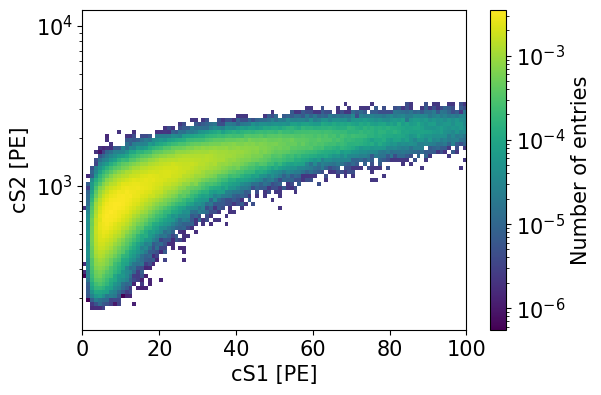

In [27]:
h_wimp, be = jnp.histogramdd(
    jnp.asarray([cs1_wimp, cs2_wimp]).T, 
    bins=(jnp.linspace(*x_clip, 101), 
          jnp.logspace(*np.log10(y_clip), 81)), 
    weights=eff_wimp
)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.8))
h_wimp = mh.Histdd.from_histogram(
    np.array(h_wimp), 
    be, 
    axis_names=['cS1 [PE]', 'cS2 [PE]']
)
h_wimp.plot(norm=LogNorm())
plt.yscale('log')
# plt.savefig('wimp_band_50GeV.svg', transparent=True)

plt.show()

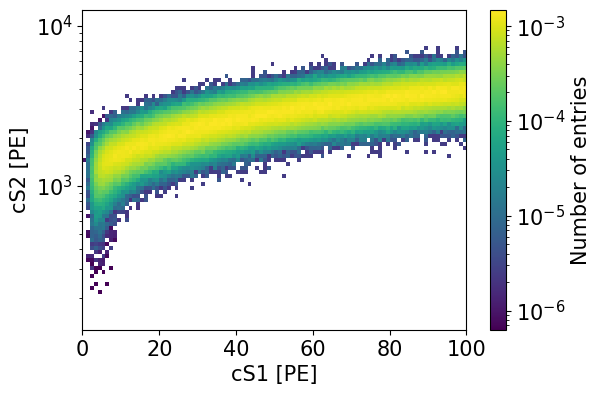

In [28]:
h_er, be = jnp.histogramdd(
    jnp.asarray([cs1_er, cs2_er]).T, 
    bins=(jnp.linspace(*x_clip, 101), 
          jnp.logspace(*np.log10(y_clip), 81)), 
    weights=eff_er
)

fig = plt.figure(figsize=(6, 4))
ax = fig.add_axes((0.15, 0.15, 0.8, 0.8))
h_er = mh.Histdd.from_histogram(
    np.array(h_er), 
    be, 
    axis_names=['cS1 [PE]', 'cS2 [PE]']
)
h_er.plot(norm=LogNorm())
plt.yscale('log')
# plt.savefig('wimp_band_50GeV.svg', transparent=True)

plt.show()

In [29]:
key, h_wimp = wimp.simulate_hist(key, batch_size, parameters_nr)
h_wimp = np.array(h_wimp)

key, h_er = er.simulate_hist(key, batch_size, parameters_er)
h_er = np.array(h_er)

In [30]:
def get_score(h_er, h_wimp):
    h_sum = h_wimp + h_er
    h_sum = np.clip(h_sum, 1e-3, np.inf)
    return np.sum(h_wimp ** 2 / h_sum)

# Scan through all parameters

In [31]:
test_pars = [
    'g1',
    'g2',
    'nex_ni_ratio',
    'p_dpe',
    'py0',
    'py1',
    'py2',
    'py3',
    'py4',
    'rf0',
    'rf1',
    'w',
]

In [32]:
sigmas = np.array([-2, -1, 0, 1, 2])
_base = np.array([[post_parameters[f] for f in features]])
base = pca.transform(_base)[0]
dcquantile = t_DF.quantile(norm.cdf(sigmas))
pca_pars = np.empty((pca.n_components_, len(sigmas), pca.n_features_))

for i in range(pca.n_components_):
    for j, sigma in enumerate(sigmas):
        vec = base.copy()
        vec[i] = dcquantile.iloc[j][i]
        pca_pars[i][j] = pca.inverse_transform(vec)

ind_pars = [ind_map[par] for par in test_pars]
mc_pars = np.repeat(
    np.repeat(
        [[post_parameters[f] for f in test_pars]], len(sigmas), axis=0)[None, ...], 
    len(test_pars), axis=0)

for i, (ind, par) in enumerate(zip(ind_pars, test_pars)):
    for j, sigma in enumerate(sigmas):
        mc_pars[i][j][i] = np.quantile(chain[:, ind], norm.cdf(sigma))
        # if j == 2:
        #     mc_pars[i][j][i] = post_parameters[par]

In [33]:
N = 10

scores = np.empty((len(test_pars) + pca.n_components_, len(sigmas), N))
for i, par in tqdm(enumerate(test_pars + list(range(pca.n_components_))), total=len(scores)):
    parameters = copy.deepcopy(post_parameters)
    for j, sigma in enumerate(sigmas):
        if i < len(test_pars):
            parameters.update(dict(zip(test_pars, mc_pars[i][j])))
        else:
            parameters.update(dict(zip(features, pca_pars[i - len(test_pars)][j])))
        for k in range(N):
            key, h_er = er.simulate_hist(key, batch_size, parameters)
            h_er = np.array(h_er)
            scores[i, j, k] = get_score(h_er, h_wimp)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 22/22 [01:54<00:00,  5.21s/it]


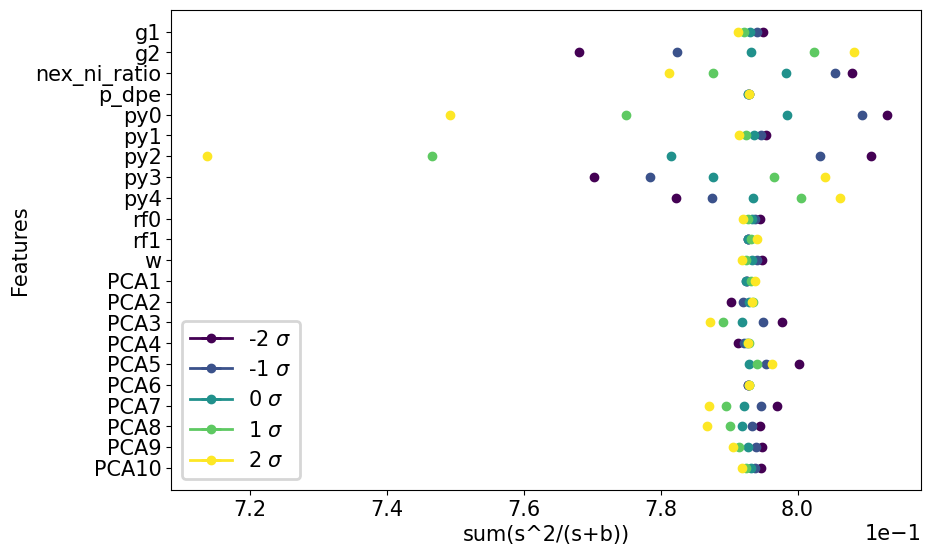

In [34]:
cmap = cm.viridis
c_norm = Normalize(vmin=sigmas[0], vmax=sigmas[-1])

fig = plt.figure(figsize=(10, 6))
# fig.tight_layout()
gs = gridspec.GridSpec(1, 1, figure=fig, left=0.2, right=0.95, top=0.95, bottom=0.15, wspace=0.25, hspace=0.25)

ax = fig.add_subplot(gs[0, 0])

_pars = test_pars + list(t_DF.columns)
for i, par in enumerate(_pars):
    for j, sigma in enumerate(sigmas):
        if i == len(_pars) - 1:
            ax.errorbar(
                scores[i, j].mean(), -i, 
                xerr=scores[i, j].std(), 
                color=cmap(c_norm(sigma)), fmt='-o', label=f'{sigma}'+' $\sigma$')
        else:
            ax.errorbar(
                scores[i, j].mean(), -i, 
                xerr=scores[i, j].std(), 
                color=cmap(c_norm(sigma)), fmt='-o')

ax.set_xlabel('sum(s^2/(s+b))')
ax.set_ylabel('Features')
ax.set_yticks(-np.arange(len(_pars)), _pars)
# ax.set_xlim(*par_config[key]['allowed_range'])
ax.xaxis.get_major_formatter().set_powerlimits((0, 0))
# ax.yaxis.get_major_formatter().set_powerlimits((0, 0))
ax.grid()
ax.legend(loc='lower left')

fig.savefig('pca_ranking.svg', transparent=True)

plt.show()